In [520]:
import os
from dataclasses import dataclass

import numpy as np

import networkx as nx

import pytorch_lightning as pl
import torch

from tensordict import TensorDict
from torch.utils.data import DataLoader

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from causica.datasets.causica_dataset_format import DataEnum, load_data
from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.tensordict_utils import tensordict_shapes
from causica.distributions import (
    AdjacencyDistribution,
    ContinuousNoiseDist,
    DistributionModule,
    ENCOAdjacencyDistributionModule,
    GibbsDAGPrior,
    JointNoiseModule,
    SEMDistributionModule,
    create_noise_modules,
)
from causica.functional_relationships import ICGNN
from causica.graph.dag_constraint import calculate_dagness
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 14

**Causal discovery and machine learning – from discovery to end-to-end process & beyond**



In [286]:
# Set random seed
SEED = 11
np.random.seed(SEED)
pl.seed_everything(SEED)  

## Data

In [287]:
nx.__version__

'2.8.7'

In [396]:
# Generate a scale-free adjacency matrix
adj_matrix = DAG.scale_free(
    n_nodes=4,
    n_edges=6,
    seed=SEED
)

# Generate the simulation
dataset = IIDSimulation(
    W=adj_matrix, 
    n=5000, 
    method='nonlinear', 
    sem_type='mim'
)

2023-04-07 16:46:48,836 - C:\Users\aleks\anaconda3\envs\causal_book_py39_exprmnt\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


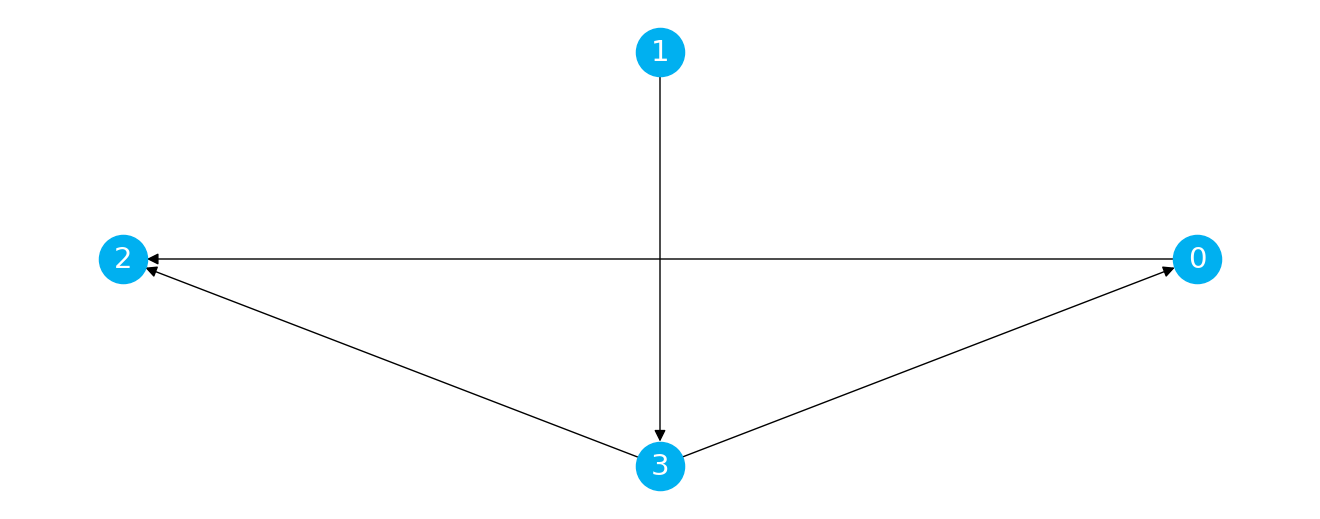

In [516]:
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(13, 5))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [ ]:
# Cast data to torch tensors
data_tensors = {}

for i in range(dataset.X.shape[1]):
    data_tensors[f'x{i}'] = torch.tensor(dataset.X[:, i].reshape(-1, 1))
    
dataset_train = TensorDict(data_tensors, torch.Size([dataset.X.shape[0]]))
    
# Move the entire dataset to the device (for big datasets move to device by batch within training loop)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

# Create loader
dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

dataset_train

## Causica DECI

### Model and optimizer configuratiomn

In [495]:
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist: ContinuousNoiseDist = ContinuousNoiseDist.SPLINE
    batch_size: int = 512
    max_epoch: int = int(os.environ.get("MAX_EPOCH", 500))  # used by testing to run the notebook as a script
    gumbel_temp: float = 0.25
    averaging_period: int = 10
    prior_sparsity_lambda: float = 4.0
    init_rho: float = 1.0
    init_alpha: float = 0.0


training_config = TrainingConfig()
auglag_config = AugLagLRConfig()

Global seed set to 11


### Set prior

In [ ]:
# To add expert knowledge:

# expert_knowledge = ExpertGraphContainer(
#     dag=torch.Tensor(adj_matrix),
#     mask=torch.Tensor(adj_matrix),
#     confidence=torch.Tensor(adj_matrix),
#     scale=200.
# )

In [499]:
num_nodes = len(dataset_train.keys())

# Define the prior
prior = GibbsDAGPrior(
    num_nodes=num_nodes, 
    sparsity_lambda=training_config.prior_sparsity_lambda,
    expert_graph_container=expert_knowledge
)

In [500]:
adjacency_dist: DistributionModule[AdjacencyDistribution] = ENCOAdjacencyDistributionModule(num_nodes)

In [501]:
icgnn = ICGNN(
    variables=tensordict_shapes(dataset_train),
    embedding_size=8, #32,
    out_dim_g=8, #32,
    norm_layer=torch.nn.LayerNorm,
    res_connection=True,
)

In [502]:
variable_shapes = tensordict_shapes(dataset_train)

types_dict = {var_name: VariableTypeEnum.CONTINUOUS for var_name in dataset_train.keys()}

noise_submodules = create_noise_modules(variable_shapes, types_dict, training_config.noise_dist)
noise_module = JointNoiseModule(noise_submodules)

In [503]:
sem_module: SEMDistributionModule = SEMDistributionModule(adjacency_dist, icgnn, noise_module)
sem_module.to(device)

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): ICGNN(
    (nn): FGNNI(
      (g): Sequential(
        (0): Sequential(
          (0): Linear(in_features=12, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64, out_features=64, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=64, out_features=8, bias=True)
        (4): Identity()
      )
      (f): Sequential(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((64,), eps=1e-05, ele

In [504]:
modules = {
    "icgnn": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}
parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

optimizer = torch.optim.Adam(parameter_list)

In [505]:
scheduler = AugLagLR(config=auglag_config)

auglag_loss = AugLagLossCalculator(
    init_alpha=training_config.init_alpha, 
    init_rho=training_config.init_rho
)

epoch:0 loss:8.108 nll:8.107 dagness:0.00000 num_edges:3 alpha:0 rho:1 step:0|1 num_lr_updates:0


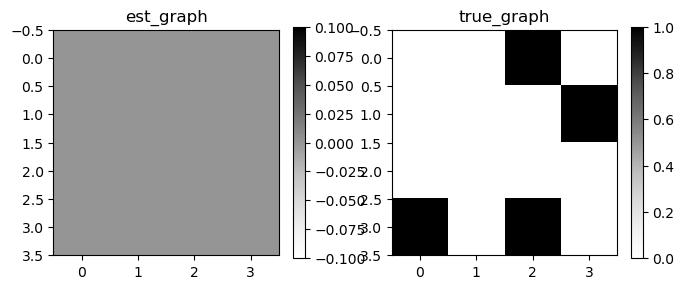

epoch:10 loss:6.2498 nll:6.2456 dagness:0.00000 num_edges:6 alpha:0 rho:1 step:0|101 num_lr_updates:0


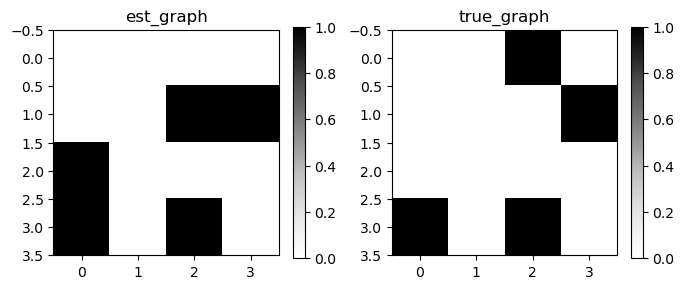

epoch:20 loss:6.0183 nll:6.0148 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:0|201 num_lr_updates:0


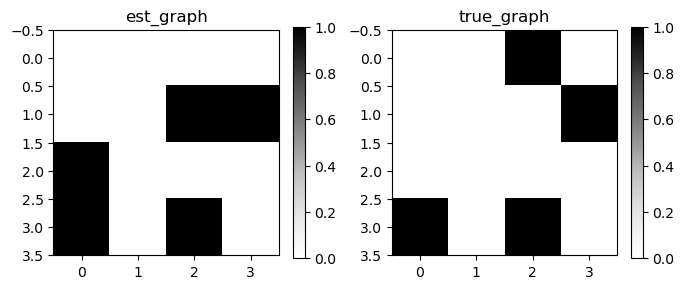

epoch:30 loss:6.0262 nll:6.0235 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:0|301 num_lr_updates:0


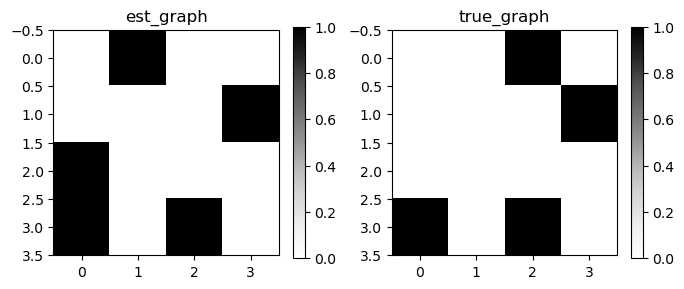

epoch:40 loss:6.2243 nll:6.2207 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|401 num_lr_updates:0


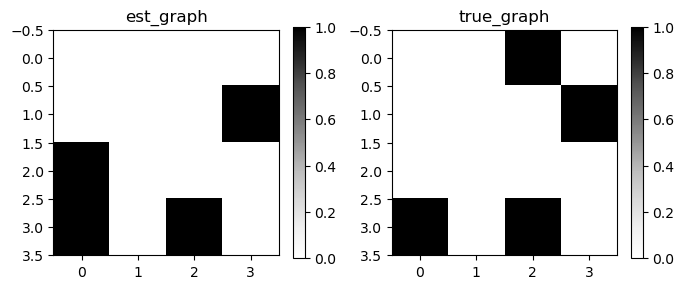

epoch:50 loss:7.4954 nll:7.4917 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:0|501 num_lr_updates:0


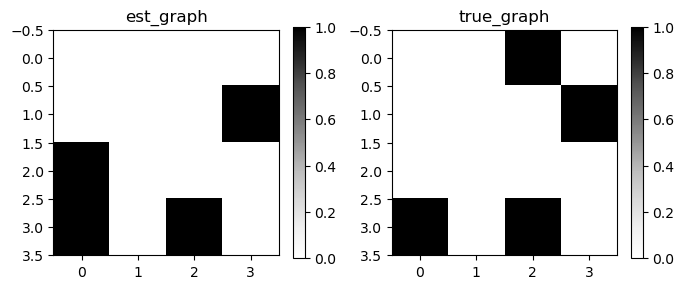

epoch:60 loss:9.3338 nll:9.3309 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:0|601 num_lr_updates:1


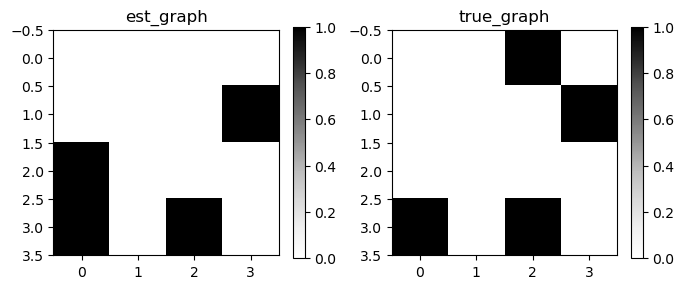

epoch:70 loss:9.1481 nll:9.1452 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:0|701 num_lr_updates:1


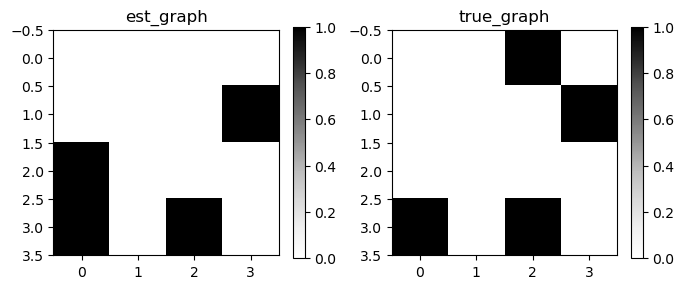

epoch:80 loss:9.0204 nll:9.0159 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|801 num_lr_updates:1


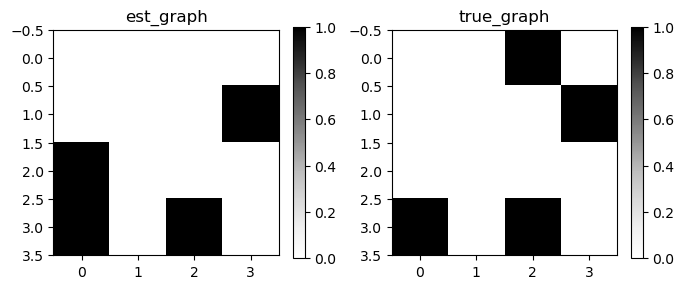

Updating alpha to: 0.5041751861572266
epoch:90 loss:11.784 nll:11.782 dagness:0.00000 num_edges:3 alpha:0.50418 rho:1 step:1|75 num_lr_updates:0


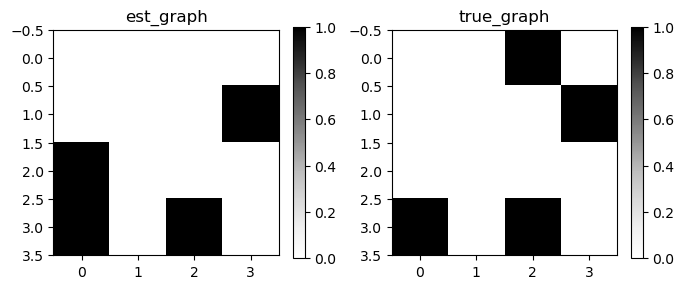

epoch:100 loss:11.729 nll:11.725 dagness:0.00000 num_edges:5 alpha:0.50418 rho:1 step:1|175 num_lr_updates:0


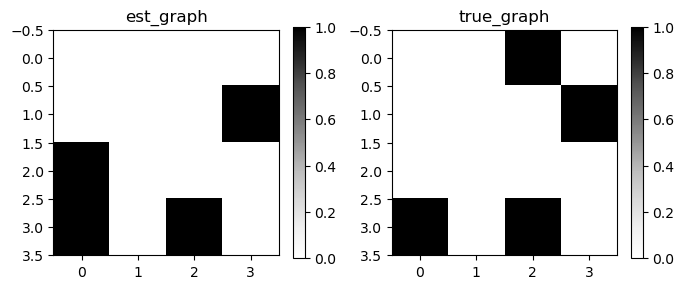

epoch:110 loss:12.74 nll:12.737 dagness:0.00000 num_edges:4 alpha:0.50418 rho:1 step:1|275 num_lr_updates:0


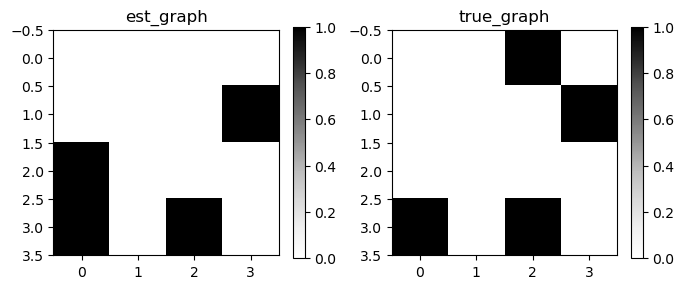

epoch:120 loss:11.668 nll:11.665 dagness:0.00000 num_edges:5 alpha:0.50418 rho:1 step:1|375 num_lr_updates:0


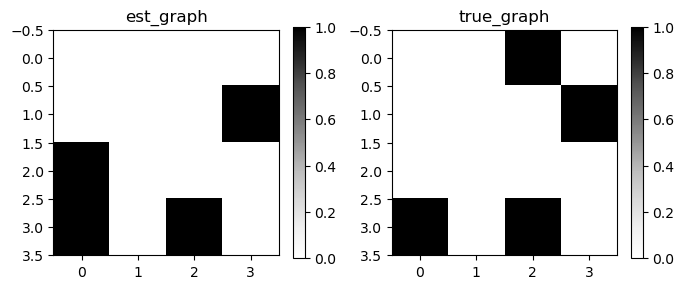

epoch:130 loss:11.593 nll:11.589 dagness:1.18629 num_edges:6 alpha:0.50418 rho:1 step:1|475 num_lr_updates:0


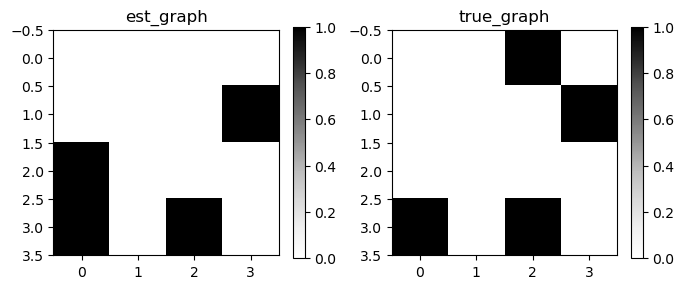

Updating alpha to: 2.520875930786133
epoch:140 loss:11.567 nll:11.564 dagness:0.00000 num_edges:4 alpha:2.5209 rho:1 step:2|55 num_lr_updates:0


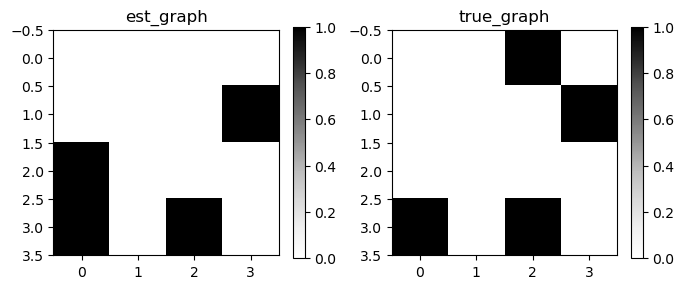

epoch:150 loss:12.073 nll:12.069 dagness:0.67233 num_edges:5 alpha:2.5209 rho:1 step:2|155 num_lr_updates:0


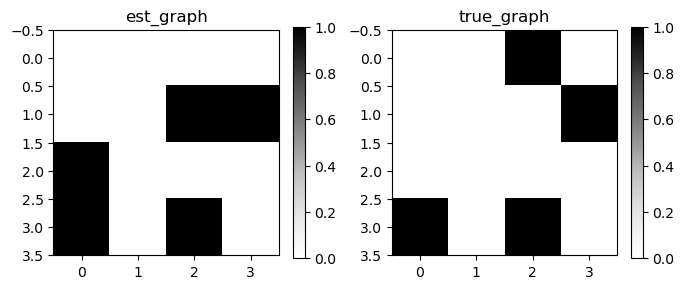

epoch:160 loss:14.126 nll:14.123 dagness:0.00000 num_edges:4 alpha:2.5209 rho:1 step:2|255 num_lr_updates:0


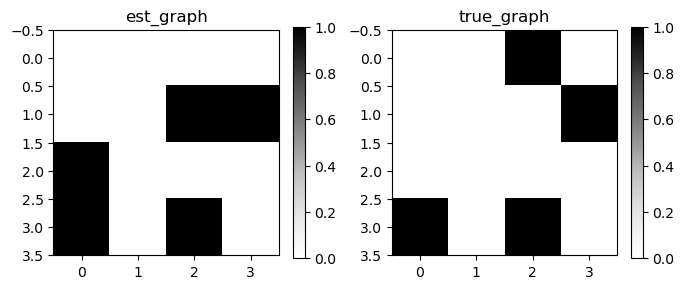

epoch:170 loss:12.171 nll:12.166 dagness:1.18629 num_edges:6 alpha:2.5209 rho:1 step:2|355 num_lr_updates:0


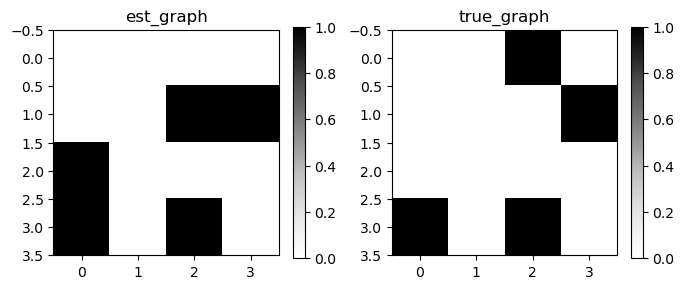

epoch:180 loss:12.627 nll:12.622 dagness:1.18629 num_edges:6 alpha:2.5209 rho:1 step:2|455 num_lr_updates:0


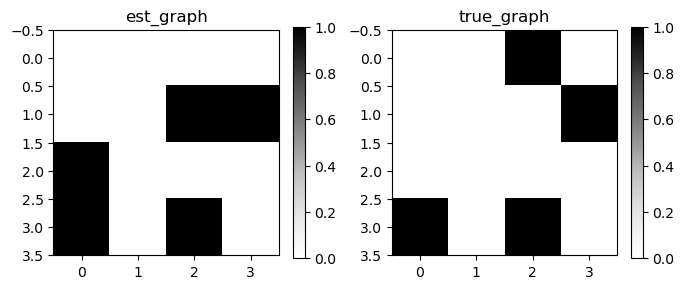

Updating alpha to: 12.604379653930664
epoch:190 loss:12.274 nll:12.27 dagness:0.00000 num_edges:5 alpha:12.604 rho:1 step:3|9 num_lr_updates:0


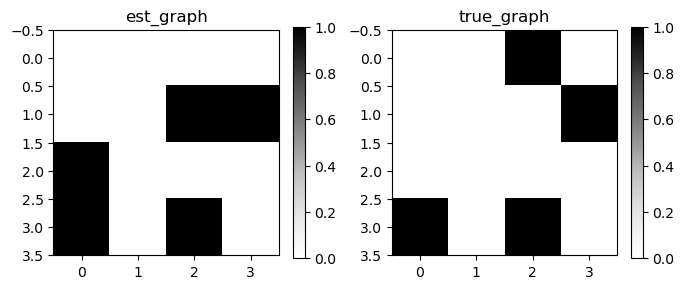

epoch:200 loss:12.77 nll:12.766 dagness:0.00000 num_edges:5 alpha:12.604 rho:1 step:3|109 num_lr_updates:0


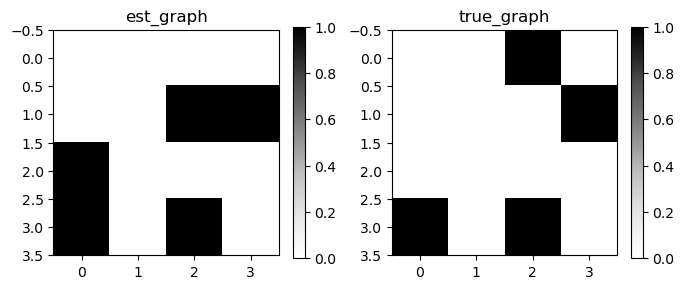

epoch:210 loss:12.954 nll:12.951 dagness:0.00000 num_edges:4 alpha:12.604 rho:1 step:3|209 num_lr_updates:0


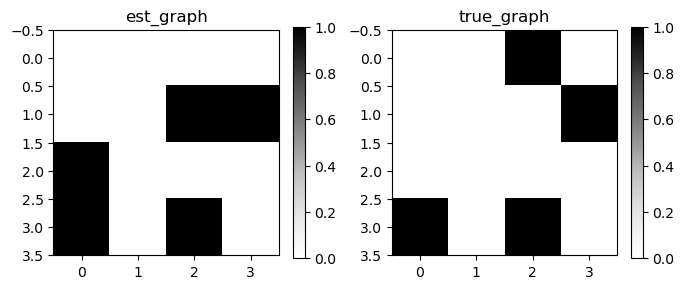

epoch:220 loss:12.723 nll:12.72 dagness:0.00000 num_edges:5 alpha:12.604 rho:1 step:3|309 num_lr_updates:0


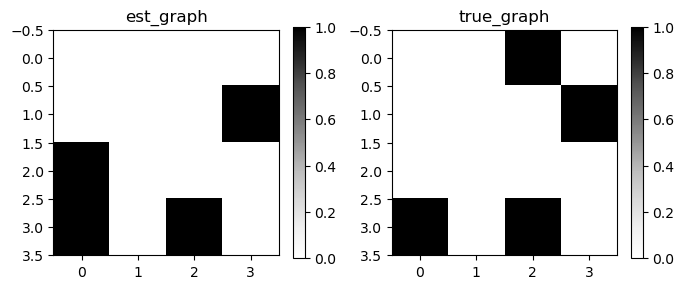

epoch:230 loss:12.511 nll:12.508 dagness:0.00000 num_edges:4 alpha:12.604 rho:1 step:3|409 num_lr_updates:0


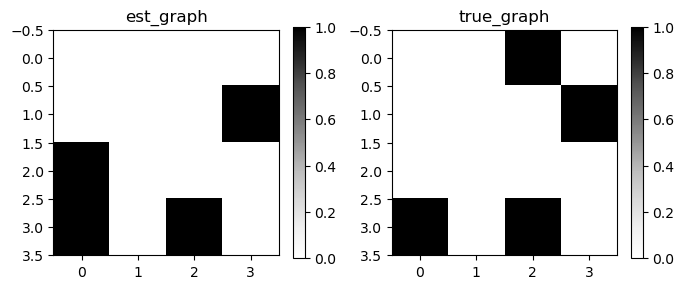

epoch:240 loss:12.983 nll:12.98 dagness:0.00000 num_edges:4 alpha:12.604 rho:1 step:3|509 num_lr_updates:1


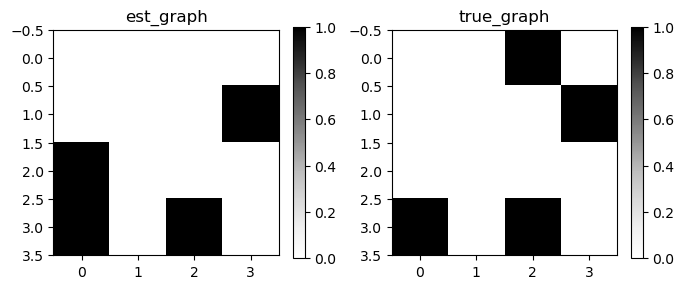

Updating alpha to: 63.02189826965332
epoch:250 loss:12.868 nll:12.864 dagness:0.00000 num_edges:5 alpha:63.022 rho:1 step:4|89 num_lr_updates:0


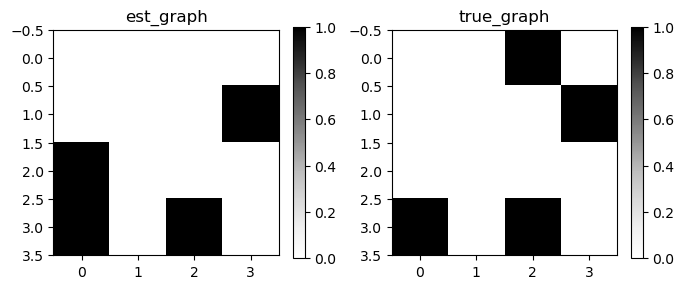

epoch:260 loss:13.037 nll:13.034 dagness:0.00000 num_edges:4 alpha:63.022 rho:1 step:4|189 num_lr_updates:0


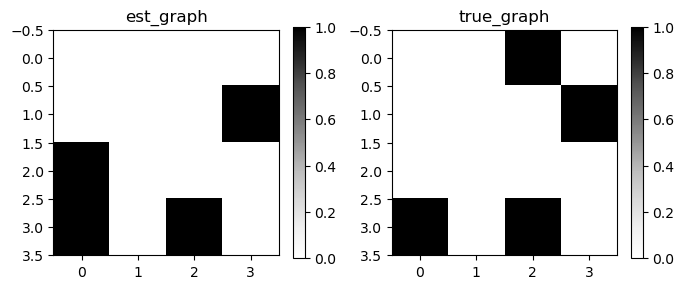

epoch:270 loss:13.094 nll:13.091 dagness:0.00000 num_edges:4 alpha:63.022 rho:1 step:4|289 num_lr_updates:0


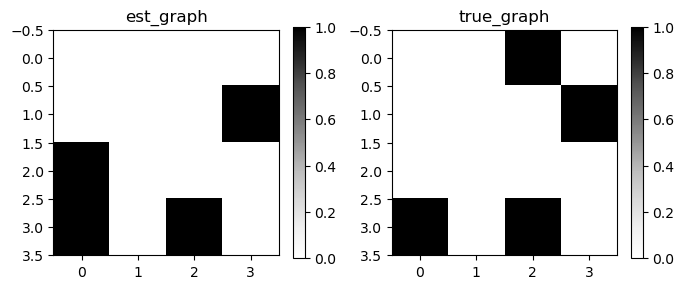

epoch:280 loss:13.664 nll:13.661 dagness:0.00000 num_edges:4 alpha:63.022 rho:1 step:4|389 num_lr_updates:0


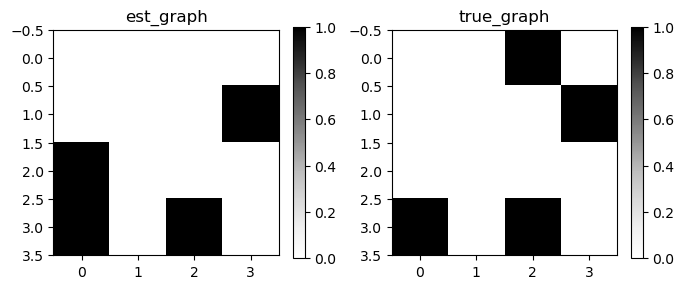

epoch:290 loss:13.585 nll:13.581 dagness:0.00000 num_edges:5 alpha:63.022 rho:1 step:4|489 num_lr_updates:0


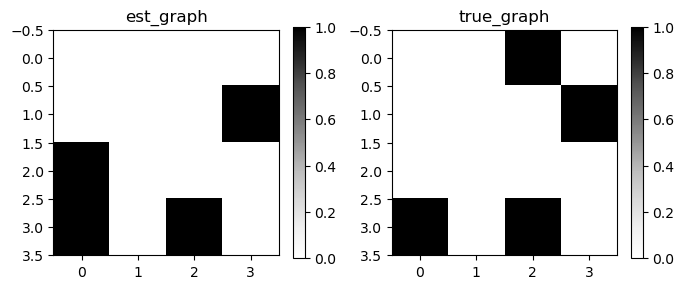

Updating alpha to: 315.1094913482666
epoch:300 loss:13.252 nll:13.249 dagness:0.00000 num_edges:4 alpha:315.11 rho:1 step:5|43 num_lr_updates:0


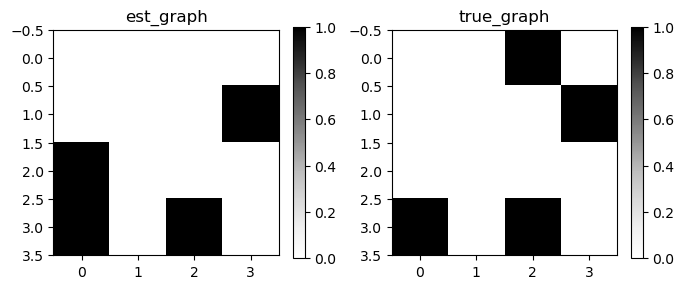

epoch:310 loss:13.087 nll:13.084 dagness:0.00000 num_edges:4 alpha:315.11 rho:1 step:5|143 num_lr_updates:0


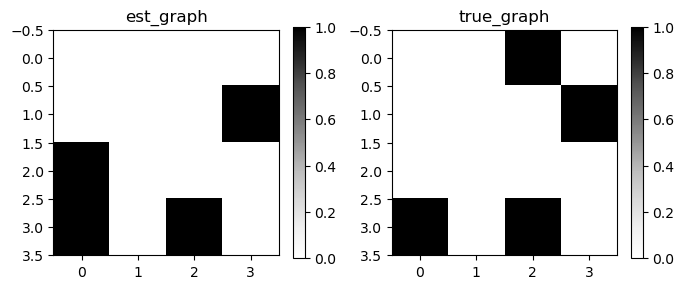

epoch:320 loss:13.167 nll:13.164 dagness:0.00000 num_edges:4 alpha:315.11 rho:1 step:5|243 num_lr_updates:0


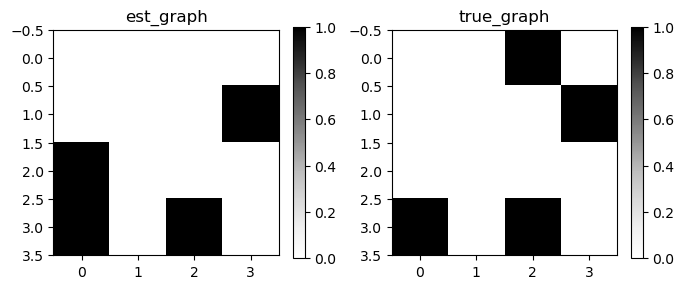

epoch:330 loss:13.28 nll:13.277 dagness:0.00000 num_edges:4 alpha:315.11 rho:1 step:5|343 num_lr_updates:0


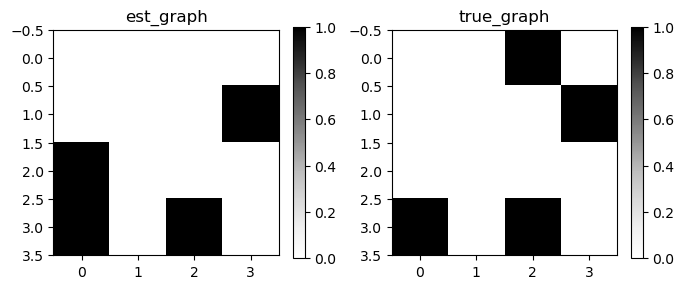

epoch:340 loss:13.317 nll:13.313 dagness:0.00000 num_edges:5 alpha:315.11 rho:1 step:5|443 num_lr_updates:0


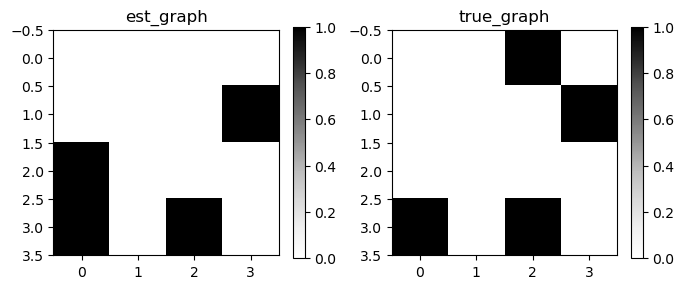

epoch:350 loss:13.406 nll:13.402 dagness:0.00000 num_edges:5 alpha:315.11 rho:1 step:5|543 num_lr_updates:0


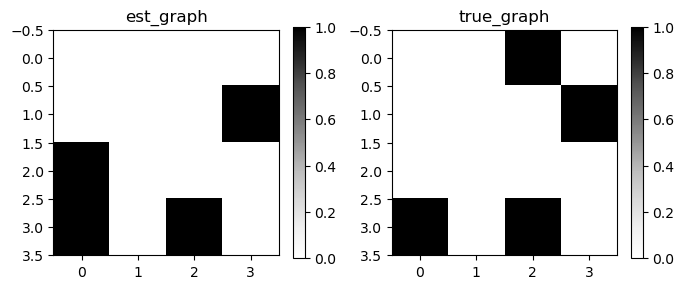

epoch:360 loss:13.336 nll:13.332 dagness:0.00000 num_edges:4 alpha:315.11 rho:1 step:5|643 num_lr_updates:1


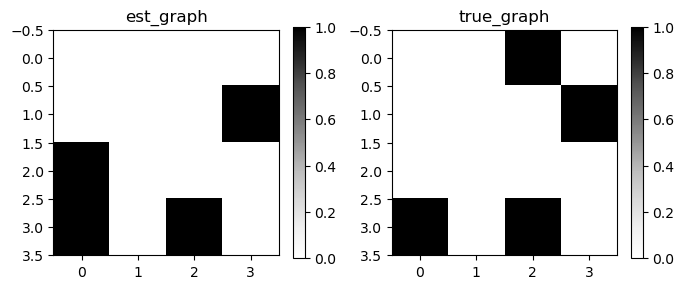

epoch:370 loss:13.284 nll:13.281 dagness:0.00000 num_edges:4 alpha:315.11 rho:1 step:5|743 num_lr_updates:1


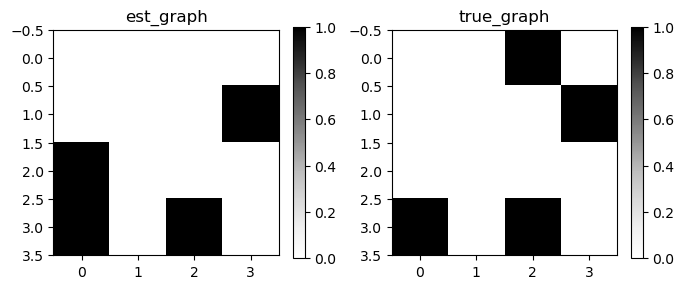

Updating alpha to: 1575.547456741333
epoch:380 loss:13.215 nll:13.212 dagness:0.00000 num_edges:4 alpha:1575.5 rho:1 step:6|35 num_lr_updates:0


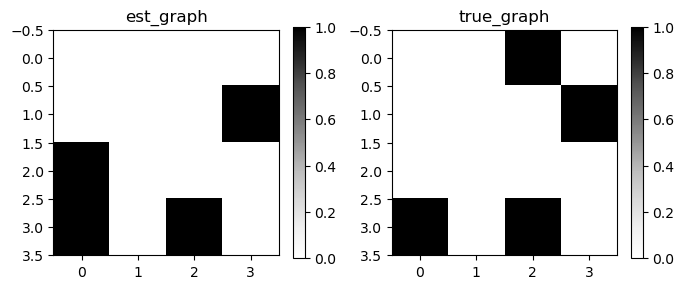

epoch:390 loss:13.234 nll:13.23 dagness:0.00000 num_edges:5 alpha:1575.5 rho:1 step:6|135 num_lr_updates:0


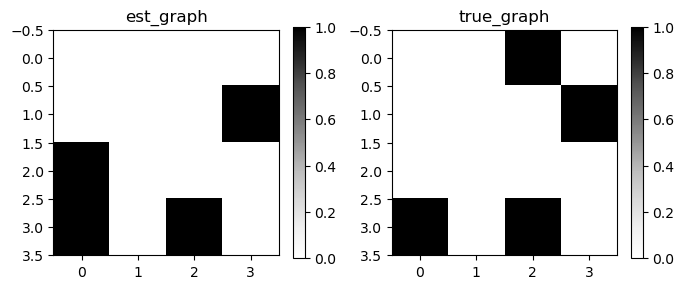

epoch:400 loss:13.49 nll:13.487 dagness:0.00000 num_edges:4 alpha:1575.5 rho:1 step:6|235 num_lr_updates:0


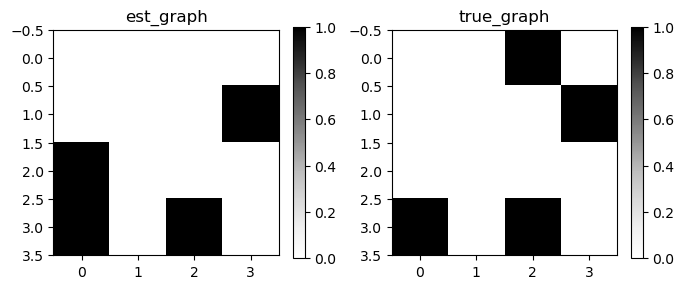

epoch:410 loss:13.266 nll:13.263 dagness:0.00000 num_edges:5 alpha:1575.5 rho:1 step:6|335 num_lr_updates:0


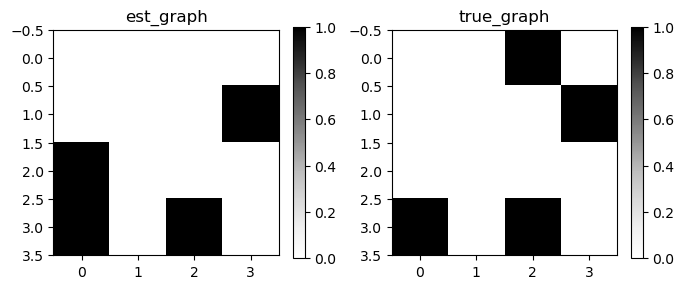

epoch:420 loss:13.401 nll:13.398 dagness:0.00000 num_edges:4 alpha:1575.5 rho:1 step:6|435 num_lr_updates:0


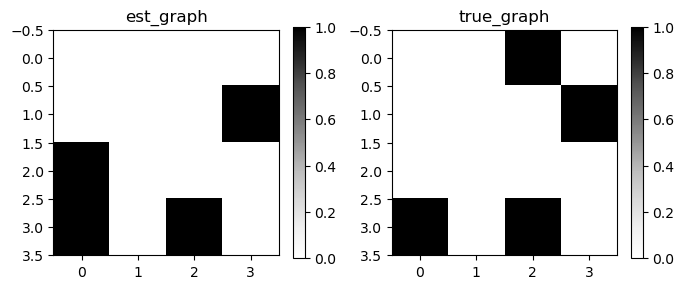

epoch:430 loss:13.265 nll:13.261 dagness:0.00000 num_edges:5 alpha:1575.5 rho:1 step:6|535 num_lr_updates:1


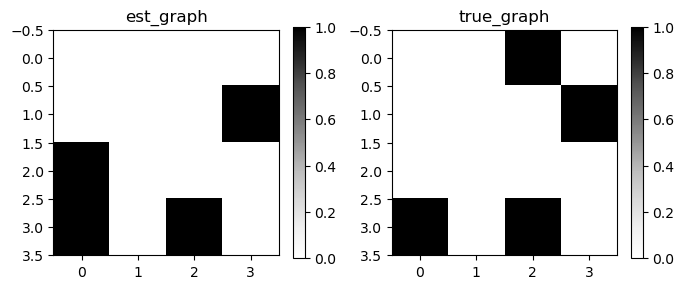

epoch:440 loss:13.088 nll:13.085 dagness:0.00000 num_edges:4 alpha:1575.5 rho:1 step:6|635 num_lr_updates:1


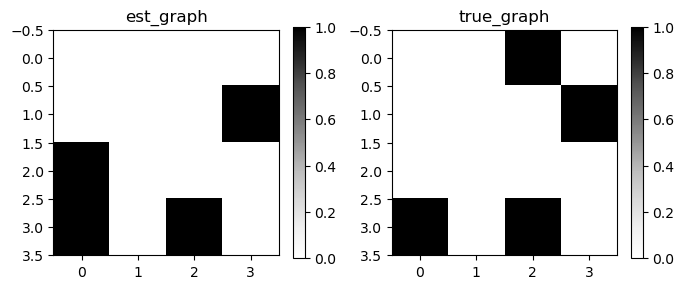

epoch:450 loss:13.062 nll:13.059 dagness:0.00000 num_edges:4 alpha:1575.5 rho:1 step:6|735 num_lr_updates:1


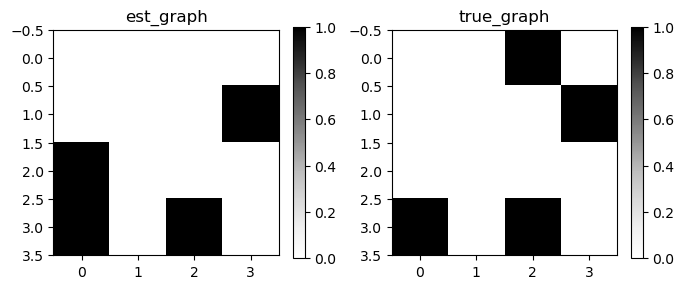

epoch:460 loss:13.188 nll:13.186 dagness:0.00000 num_edges:3 alpha:1575.5 rho:1 step:6|835 num_lr_updates:1


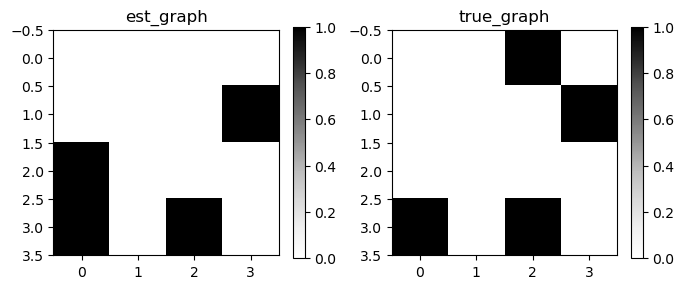

epoch:470 loss:13.299 nll:13.296 dagness:0.00000 num_edges:5 alpha:1575.5 rho:1 step:6|935 num_lr_updates:1


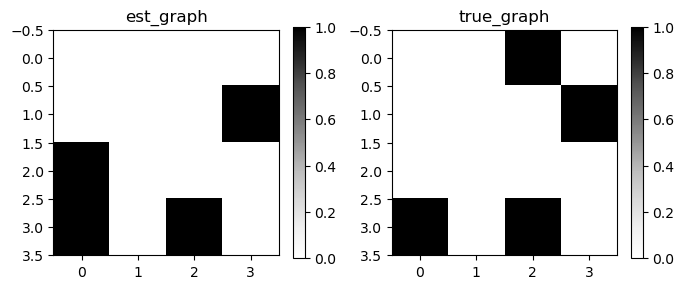

epoch:480 loss:13.323 nll:13.32 dagness:0.00000 num_edges:4 alpha:1575.5 rho:1 step:6|1035 num_lr_updates:2


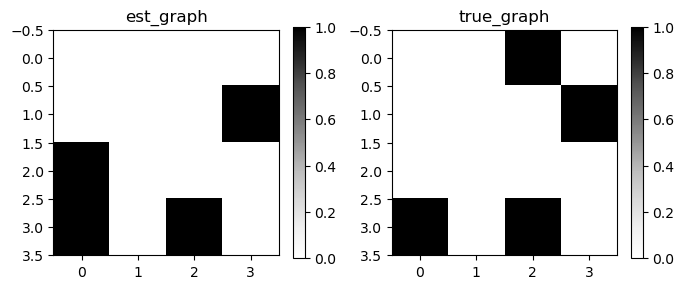

epoch:490 loss:13.359 nll:13.357 dagness:0.00000 num_edges:3 alpha:1575.5 rho:1 step:6|1135 num_lr_updates:2


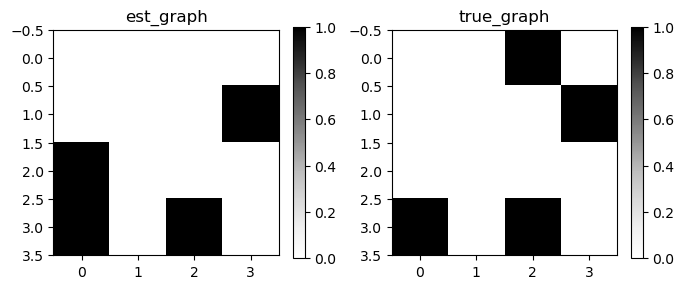

In [506]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"

num_samples = len(dataset_train)

for epoch in range(training_config.max_epoch):
    
    for i, batch in enumerate(dataloader_train):
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Get SEM 
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), 
            temperature=training_config.gumbel_temp
        )  # soft sample
        
        # Compute the log probability of data
        batch_log_prob = sem.log_prob(batch).mean()
        
        # Get the distribution entropy
        sem_distribution_entropy = sem_distribution.entropy()
        
        # Compute the likelihood of the current graph
        prior_term = prior.log_prob(sem.graph)
        
        # Compute the objective
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        
        # Compute the DAG-ness term
        constraint = calculate_dagness(sem.graph)
        
        # Compute the Lagrangian loss
        loss = auglag_loss(objective, constraint / num_samples)

        # Propagate gradients and update
        loss.backward()
        optimizer.step()
        
        # Update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss.item(),
            lagrangian_penalty=constraint.item(),
        )
        
        # Log metrics & plot the matrices
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )
            
            vardist = adjacency_dist()
            pred_dag = vardist.mode.cpu().numpy()

            plt.style.use('default')

            GraphDAG(
                est_dag=pred_dag, 
                true_dag=adj_matrix)

            plt.show()

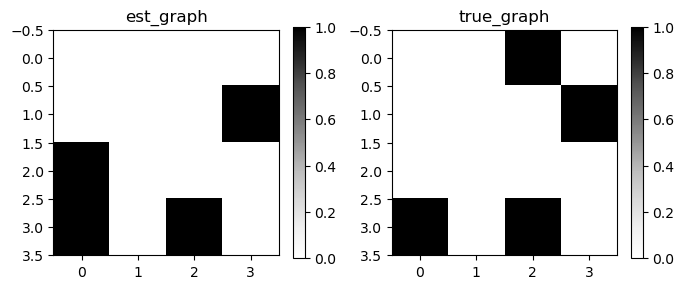

In [507]:
# Sample from the distribution of graphs
vardist = adjacency_dist()
pred_dag = vardist.mode.cpu().numpy()


# Plot the final graph vs the ground truth
plt.style.use('default')

GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [508]:
# Compute and print the metrics
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

metrics.metrics

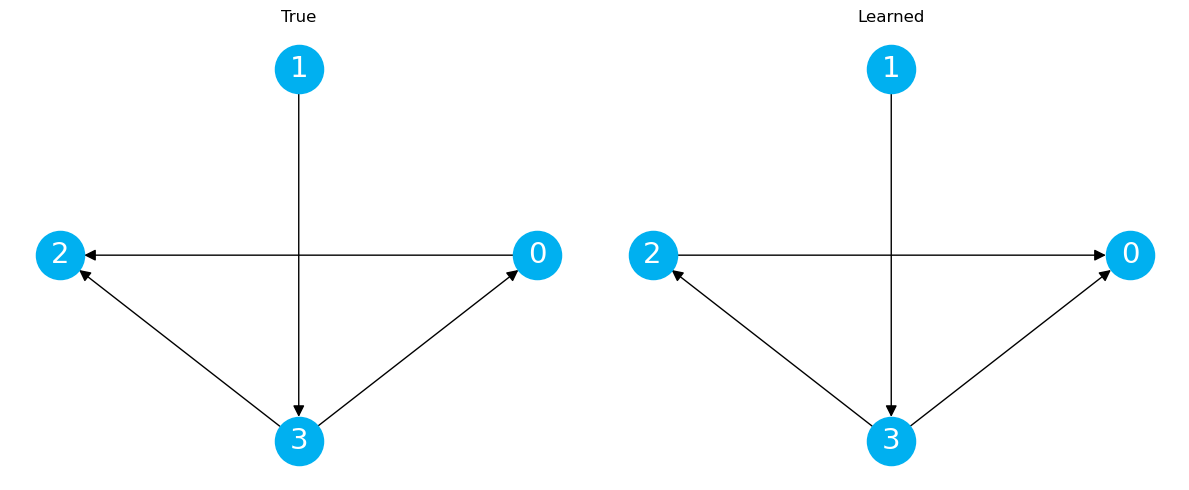

In [510]:
# Plot the predicted graph against the true DAG
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(12, 5))

plt.subplot(121)
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)
plt.title('True')

plt.subplot(122)
nx.draw(
    G=nx.DiGraph(pred_dag),
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(nx.DiGraph(pred_dag))
)
plt.title('Learned')

plt.tight_layout()
plt.show()